# Main Line Pressure and Flow Estimator

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Functions as fun

Let's get everything from previous notebooks:

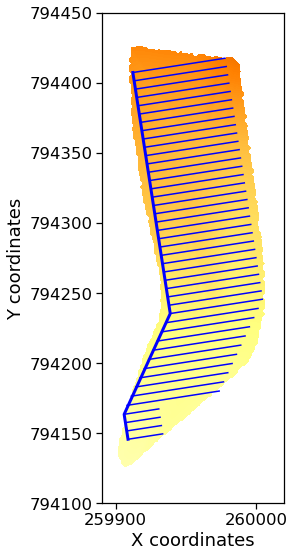

In [2]:
lines = fun.import_lines()
main_line = fun.import_main_line()
fun.plot_map(False, False) # Plotting map
plt.grid(b=False)

for line in lines: # Plotting drip lines
    line = line.reshape(2,2)
    plt.plot(line[:,0],line[:,1],c='blue')

plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3) # Plotting main line

## From Previous Notebook

Let's use the drip estimator again for the first line using main line pressure of 24.5 m to get $q_\text{nom} = 1.5 $l/h:

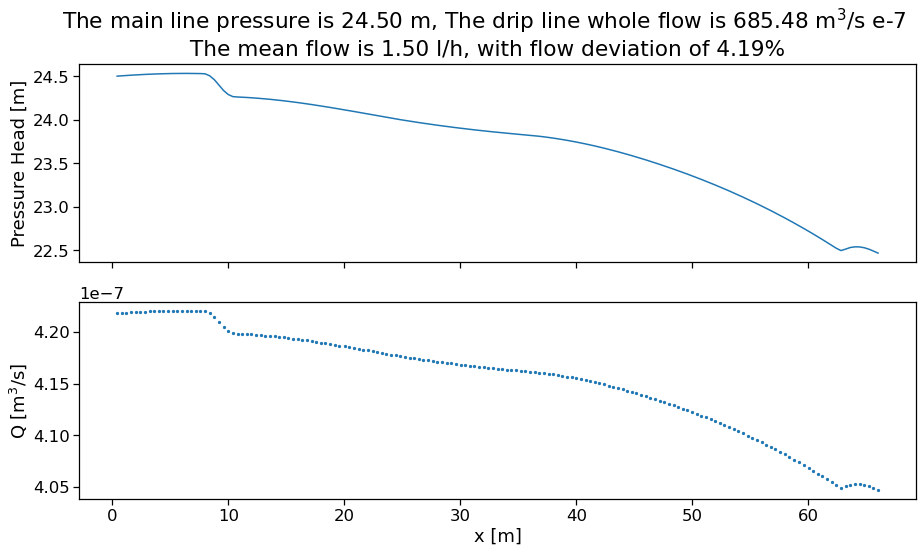

In [3]:
def estimate_line(line, main_line_pressure, plot=True):
    est = fun.DripLineEstimator() # Drip line estimator
    
    # Profile of the drip line
    profile = fun.get_profile(line,1000)
    x = profile[:,0].flatten() # Distance from main line
    zx = profile[:,1].flatten() # Altitude
    
    L = fun.calculate_distance(line) # Drip line length
    
    # Two options for the last x_emmiter value
    last_value = [66 , 24.8][np.argmin(np.absolute((np.array([66, 25]) - L)))] 
    
    # Adding the closest location of the emitter
    x_emitters = np.arange(0.4,last_value + 0.4 ,0.4)
    i = []
    for e in x_emitters:
         i.append(np.argmin(np.absolute(e - x.flatten())))
    
    
    x_emitters = x[i] # All of the emitter x values (distance from main line)
    z_emitters = zx[i] # All of the emitter z values (altitude)
    
    x_main_line = x[0] # Main line distance from main line = 0 (it's necessary for later calculations)
    z_main_line = zx[0] # Main line altitude (in the connection to the drip line)

    # Estimating all of the emitters pressure and flow, and the main line pressure.
    P_line,Q_line,P_main_line = est.estimate(main_line_pressure, x_main_line, x_emitters, z_main_line, z_emitters)
    
    if plot:
        fig, axes = plt.subplots(2,1, figsize=(15,8),sharex=True) 
        axes[0].plot(x_emitters,P_line)
        axes[1].scatter(x_emitters,Q_line,s=5)

        axes[0].set_ylabel('Pressure Head [m]')
        axes[1].set_ylabel(r'Q [m$^3$/s]')
        axes[1].set_xlabel('x [m]')

        flow_deviation = (np.max(Q_line) - np.min(Q_line)) / np.mean(Q_line) * 100 # [%]
        mean_flow_l_h =  np.mean(Q_line) * 3600 * 1000
        title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'.format(P_main_line, (np.sum(Q_line)*1e7))
        title = title + '\n The mean flow is {:.2f} l/h, with flow deviation of {:.2f}%\n'.format(mean_flow_l_h, flow_deviation)
        fig.suptitle(title)
    return P_line,Q_line,P_main_line
    
P_line,Q_line,P_main_line = estimate_line(lines[0].reshape(2,2),24.5)

In [4]:
# Let's check if there are really 165 emitter counted
len(P_line)

165

Let's see it for the last line:

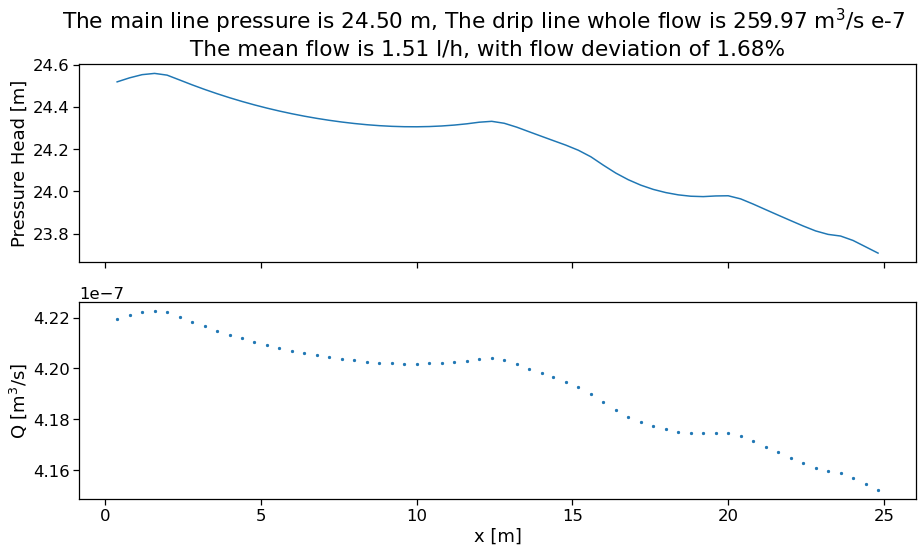

In [5]:
P_line,Q_line,P_main_line = estimate_line(lines[43].reshape(2,2),24.5)

In [6]:
# Let's check if there are really 62 emitter counted
len(P_line)

62

# Calculating Main Line Pressure

The approach is the same as we did for the drip line. When we're given with the pressure value at the start of the main line, we actually start the calculation from the last (bottom) connection point of the main line to the drip line. We assume we know this terminal pressure and then start:


* Let's assume that we know the pressure at the last (bottom) connection point of the main line to the drip line and call it $P_N$
* Setting the main line flow $Q_\text{main}$
* Calculating the drip line whole flow $q_\text{drip}$ according to $P_0$ using the function 'estimate_line()' and adding it to $Q_\text{main}$
* Calculating the distance to from emitter $N$ to emitter $N-1$. We call it $L$.
* Calculate the section head loss according to $hf = L\left(\frac{Q_\text{main}}{C}\right)^\alpha\frac{10.67}{D^\beta}$
* Calculating the pressure at the next emitter $P_{N-1} = P_{N} + hf + Z_N - Z_{N-1}$

And so on until we get to the first drip line (at the top). Afterward we only calculate the initial pressure of the main line and checking if it matches to the initial value. If not we repeat this whole procedure with better guess to $P_N$

The pipe coeffiecients according to Naan catalog - page 48 - PVC

C = 150

D = 0.0381 m

Max P = 4 bar $\approx$ 40.82 m


In [7]:
class system():
    def __init__(self, lines, P_terminal_guess=24, D=np.repeat(0.0381, 43)):
        self.lines = lines
        self.P_main = np.array([P_terminal_guess])
        self.Q_main = np.array([])
        self.L_main = np.array([])
        self.Z_main = np.array([])
        self.q_emitters = []
        self.p_emitters = []
        self.C = 150
        self.D = D # [m] Note that D is an array, so it can varies when we combine diameters
        self.alpha = 1.852
        self.beta = 4.87
    def run(self):
        # Running all line from the last to first (excluding the first line)
        for i in np.arange(-1,-len(self.lines),-1): 
            
            # Calculating all of the drip line's emitters flow and pressure,
            # using the main line pressure - P_main[-1]
            P_dripline, Q_dripline, _ = estimate_line(self.lines[i].reshape(2,2), self.P_main[-1], False)
            
            # Saving the drip line data
            self.q_emitters.append(Q_dripline)
            self.p_emitters.append(P_dripline)
            
            # Adding the whole drip line flow to the main line data
            self.Q_main = np.append(self.Q_main, np.sum(Q_dripline))
            
            # Current (N) and previous (N-1) connection points
            cur_point = self.lines[i].reshape(2,2)[0]
            pre_point = self.lines[i-1].reshape(2,2)[0]
            
            # Calculating the distance to the previous point
            section_L = np.concatenate((cur_point,pre_point))
            self.L_main = np.append(self.L_main,fun.calculate_distance(section_L.reshape(2,2)))
            
            # Calculating the altitude for the current point and the previous (N-1)
            z = fun.interpolate_altitude(cur_point)[0]
            z_pre = fun.interpolate_altitude(pre_point)[0]
            
            # Adding main line altitude to data
            self.Z_main = np.append(self.Z_main, z)
                
            hf = self.L_main[-1] * ((np.sum(self.Q_main) / self.C) ** self.alpha) * (10.67 / (self.D[i] ** self.beta))
            self.P_main = np.append(self.P_main, hf + self.P_main[-1] + z - z_pre)
        
        # Adding the first drip line to the rest of the data:
        P_dripline, Q_dripline, _ = estimate_line(lines[0].reshape(2,2),self.P_main[-1], False)
        self.q_emitters.append(Q_dripline)
        self.p_emitters.append(P_dripline)
        self.Z_main = np.append(self.Z_main, z_pre) # The first connection point altitude
        self.Q_main = np.append(self.Q_main, np.sum(Q_dripline)) # The first drip line whole flow
        # Reversing all results
        self.x_main = np.append(0,np.cumsum(self.L_main[::-1])) # The distance of all conection points from the top
        self.P_main = self.P_main[::-1]
        self.Q_main = np.cumsum(self.Q_main)[::-1]
        self.Z_main = self.Z_main[::-1]

Let's see all of the main line pressure, flow and altitude:

Text(0, 0.5, 'Z [m]')

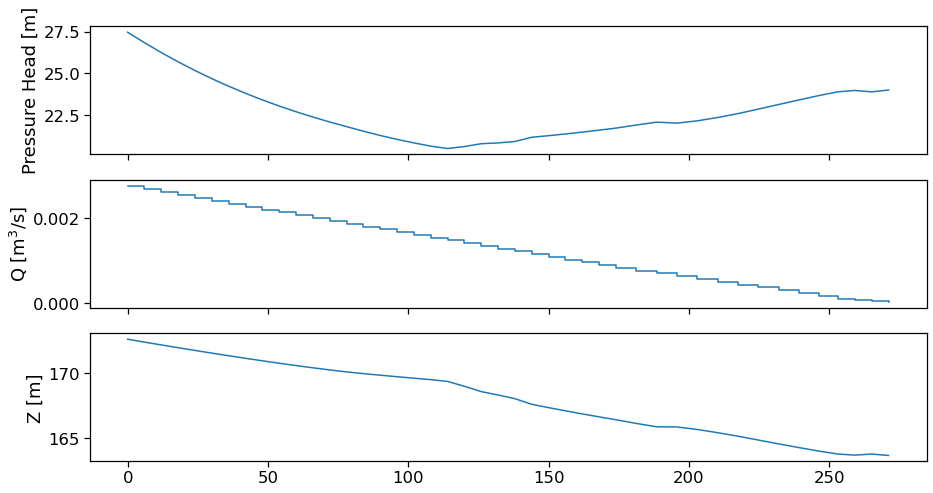

In [8]:
s = system(lines)
s.run()

x_main = s.x_main
P_main = s.P_main
Q_main = s.Q_main
Z_main = s.Z_main
q_emitters = s.q_emitters

fig, axes = plt.subplots(3,1, figsize=(15,8),sharex=True) 
axes[0].plot(x_main,P_main)
axes[0].set_ylabel('Pressure Head [m]')
axes[1].step(x_main,Q_main,where='post')
axes[1].set_ylabel(r'Q [m$^3$/s]')
axes[2].plot(x_main,Z_main)
axes[2].set_ylabel('Z [m]')

Same thing as we did to the drip line calculation, we want to set initial value to the first connection point (30 m) and get the right prediction for it (Using the objective function from the paper):

In [9]:
P_main_init = 30

def obj(variables):
    P_main_terminal = variables[0]
    s = system(lines,P_terminal_guess = P_main_terminal)
    s.run()
    return P_main_init - s.P_main[0]

from scipy.optimize import fsolve
P_main_terminal_value = fsolve(obj, P_main_init)[0] # Using initial pressure value as the guess of the terminal
P_main_terminal_value

25.665919822790645

Text(0, 0.5, 'Z [m]')

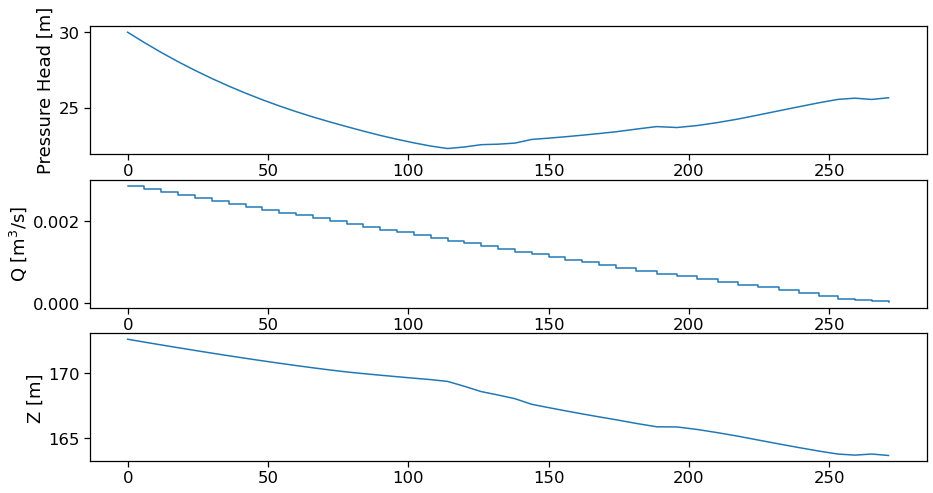

In [10]:
s = system(lines,P_main_terminal_value)
s.run()

x_main = s.x_main
P_main = s.P_main
Q_main = s.Q_main
Z_main = s.Z_main
q_emitters = s.q_emitters

fig, axes = plt.subplots(3,1, figsize=(15,8)) 
axes[0].plot(x_main,P_main)
axes[0].set_ylabel('Pressure Head [m]')
axes[1].step(x_main,Q_main,where='post')
axes[1].set_ylabel(r'Q [m$^3$/s]')
axes[2].plot(x_main,Z_main)
axes[2].set_ylabel('Z [m]')

As you can see, it works.

Let's take a look at all of the emitters data:

In [11]:
q_emitters = pd.DataFrame(q_emitters[::-1],
                         columns=['E{}'.format(i) for i in range(1,166)],
                         index=['L{}'.format(i) for i in range(1,45)]) * 1000 * 3600 # [l/h]
q_emitters

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E156,E157,E158,E159,E160,E161,E162,E163,E164,E165
L1,1.672849,1.672926,1.672998,1.673064,1.673124,1.673178,1.673225,1.673266,1.673300,1.673327,...,1.617569,1.616847,1.617307,1.617810,1.618033,1.618005,1.617753,1.617307,1.616695,1.616036
L2,1.654423,1.654539,1.654652,1.654761,1.654866,1.654967,1.655064,1.655156,1.655243,1.655325,...,1.604734,1.604791,1.604643,1.604320,1.603849,1.603259,1.602589,1.601920,1.601267,1.600629
L3,1.636750,1.636865,1.636991,1.637125,1.637258,1.637389,1.637517,1.637643,1.637766,1.637886,...,1.593030,1.592533,1.591967,1.591359,1.590745,1.590151,1.589578,1.589026,1.588497,1.587978
L4,1.619963,1.620055,1.620158,1.620272,1.620395,1.620528,1.620668,1.620810,1.620951,1.621091,...,1.581551,1.580983,1.580389,1.579757,1.579078,1.578341,1.577536,1.576652,1.575680,1.574608
L5,1.604052,1.604123,1.604204,1.604296,1.604397,1.604507,1.604625,1.604751,1.604884,1.605023,...,1.568929,1.567716,1.566368,1.564875,1.563397,1.563249,1.564372,1.565490,1.565883,1.565649
L6,1.588998,1.589048,1.589109,1.589180,1.589260,1.589349,1.589446,1.589550,1.589662,1.589779,...,1.560766,1.560810,1.560469,1.559908,1.559241,1.558725,1.558457,1.558014,1.556902,1.555327
L7,1.574780,1.574811,1.574853,1.574904,1.574965,1.575034,1.575111,1.575195,1.575286,1.575383,...,1.553572,1.552886,1.551704,1.550220,1.548841,1.547866,1.547505,1.547566,1.547814,1.548175
L8,1.561375,1.561389,1.561413,1.561446,1.561489,1.561540,1.561598,1.561664,1.561736,1.561813,...,1.542700,1.542607,1.542735,1.542984,1.543277,1.543551,1.543751,1.543818,1.543669,1.543216
L9,1.548760,1.548758,1.548766,1.548783,1.548810,1.548844,1.548885,1.548930,1.548978,1.549028,...,1.538793,1.538953,1.539041,1.538995,1.538705,1.538214,1.537627,1.537011,1.536370,1.535745
L10,1.536911,1.536895,1.536888,1.536891,1.536897,1.536908,1.536921,1.536938,1.536958,1.536981,...,1.533505,1.533112,1.532700,1.532269,1.531821,1.531357,1.530910,1.530668,1.530620,1.530631


Let's look at the maximum flow deviation of the whole system:

In [12]:
(np.nanmax(q_emitters) - np.nanmin(q_emitters)) / np.nanmax(q_emitters) * 100 # [%]

13.67140343430868

Well, it's above the 10% threshold, so we'll have to tinker with the model in next notebook. Once again, we will create our System class in Function.py which gets as arguments all of the system parameters - from the drip lines to the main line charchteristic.